In this notebook, we will design an **amortisation schedule** and then perform some data analysis on it.<br>

As an example, let’s use a fixed-rate, level-payment, fully amortised residential mortgage as an input for our amortisation schedule. A fixed-rate, level-payment, fully amortised mortgage is characterised by:<br>

-  A fixed mortgage rate over the term of the loan;
-  Equal dollar amounts of each periodic mortgage payment;
-  Reduction of mortgage balance to zero with the last mortgage payment.

Consider the following mortgage:*<br>

**Mortgage Loan:** $800,000<br>
**Mortgage Rate:** 2.183%<br>
**Term of the Loan:** 30 years<br>
**Payment Schedule:** Bi-weekly, i.e., payments every 10 business days (26 payments per year)<br>

*For simplicity, let's assume that the borrower makes no prepayments.<br><br>

In [1]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
annual_interest_rate = 0.02183
mortgage_term = 30
num_payments_per_yr = 26
mortgage = 800000
first_payment_date = date(2017, 3, 16)

Because the quoted interest rate is an annual interest rate and the borrower makes bi-weekly payments, we will have to calculate the actual rate as the annual rate divided by the number of payments in a year.<br><br>
Similarly, the number of payments over the mortgage period is the product of the mortgage term and the number of payments a year.

In [3]:
interest_rate = annual_interest_rate / num_payments_per_yr
num_periods = mortgage_term * num_payments_per_yr

**Next, we compute the payment dates.**

In [4]:
rng = pd.date_range(first_payment_date, periods=num_periods, freq='10B')
rng.name = 'Payment Date'
rng[:5]

DatetimeIndex(['2017-03-16', '2017-03-30', '2017-04-13', '2017-04-27',
               '2017-05-11'],
              dtype='datetime64[ns]', name='Payment Date', freq='10B')

**The bi-weekly payment amount is calculated as follows:**

In [5]:
pmt = round(np.pmt(interest_rate, num_periods, mortgage), 2)
pmt

-1398.3

**We are now ready to design the amortisation schedule.**

In [6]:
beginning_bal = mortgage

principal = round(np.ppmt(pv=mortgage, rate=interest_rate, nper=num_periods, per=num_periods, fv=0), 2)

interest = np.ipmt(pv=mortgage, rate=interest_rate, nper=num_periods, per=num_periods, fv=0)

ending_bal = np.pv(fv=0, pmt=pmt, rate=interest_rate, nper=0)

In [7]:
records=[]
end_bal = mortgage

for i in range(1, len(rng)+1):
    bgn_bal = end_bal
    
    principal = np.ppmt(pv=mortgage, rate=interest_rate, nper=num_periods, per=i, fv=0)
    
    interest = float(np.ipmt(pv=mortgage, rate=interest_rate, nper=num_periods, per=i, fv=0))
    
    end_bal = np.pv(fv=0, pmt=pmt, rate=interest_rate, nper=len(rng)-i)
    
    records.append((bgn_bal, -pmt, -principal, -interest, end_bal))

In [8]:
columns=['Beginning Balance', 'Payment', 'Principal', 'Interest', 'Ending Balance']

In [9]:
amort_df = pd.DataFrame.from_records(records, index=rng, columns=columns).round(2)

In [10]:
amort_df.head(5)

,Beginning Balance,Payment,Principal,Interest,Ending Balance
Payment Date,,,,,
2017-03-16,800000.00,1398.3,726.61,671.69,799272.90
2017-03-30,799272.90,1398.3,727.22,671.08,798545.69
2017-04-13,798545.69,1398.3,727.83,670.47,797817.86
2017-04-27,797817.86,1398.3,728.44,669.86,797089.42
2017-05-11,797089.42,1398.3,729.05,669.25,796360.37


# Time for some data analysis

<br>
**What is the last payment date for the mortgage?**<br>
This is easily answered by looking at the last row of the DataFrame.

In [11]:
amort_df.tail(1)

,Beginning Balance,Payment,Principal,Interest,Ending Balance
Payment Date,,,,,
2047-01-24,1397.13,1398.3,1397.13,1.17,-0.0


As shown above, the last payment of $1398.3 is scheduled for **Jan. 24, 2047**.<br>

**What is the total interest payment over the life of the loan?**

In [12]:
'Total interest payment over the life of the loan is {0}.'.format(int(amort_df.sum()['Interest']))

'Total interest payment over the life of the loan is 290674.'

**What are the total principal and interest payments per year?**

In [13]:
amort_df.groupby(by=amort_df.index.year).sum()[['Principal', 'Interest']].head(5)

,Principal,Interest
Payment Date,,
2017,15387.58,13976.72
2018,19430.92,16924.94
2019,19859.53,16496.27
2020,21087.22,16666.91
2021,20762.86,15592.98


**In which months of a year will the borrower make 3, instead of 2, payments?**<br>
Since there are 26 payments made in a year, there will be 2 months every year where the borrower will have to make 3--instead of 2--payments. These months can be found as:<br>

In [14]:
new_df = amort_df.groupby(by=[amort_df.index.year, amort_df.index.month]).count()['Payment']
new_df[new_df==3]

Payment Date  Payment Date
2017          8               3
2018          3               3
              8               3
2019          1               3
              8               3
2020          1               3
              7               3
              12              3
2021          7               3
              12              3
2022          6               3
              12              3
2023          6               3
              11              3
2024          5               3
              10              3
2025          5               3
              10              3
2026          4               3
              10              3
2027          4               3
              9               3
2028          3               3
              8               3
2029          3               3
              8               3
2030          1               3
              8               3
2031          1               3
              7               3
             

The output shows that, in 2023, the borrower will make 3 payments each in months 6 (June) and 11 (November).<br>

**We know that the balance of the loan gradually declines until it reaches zero at maturity. Let’s see a graphical representation of this decline.**

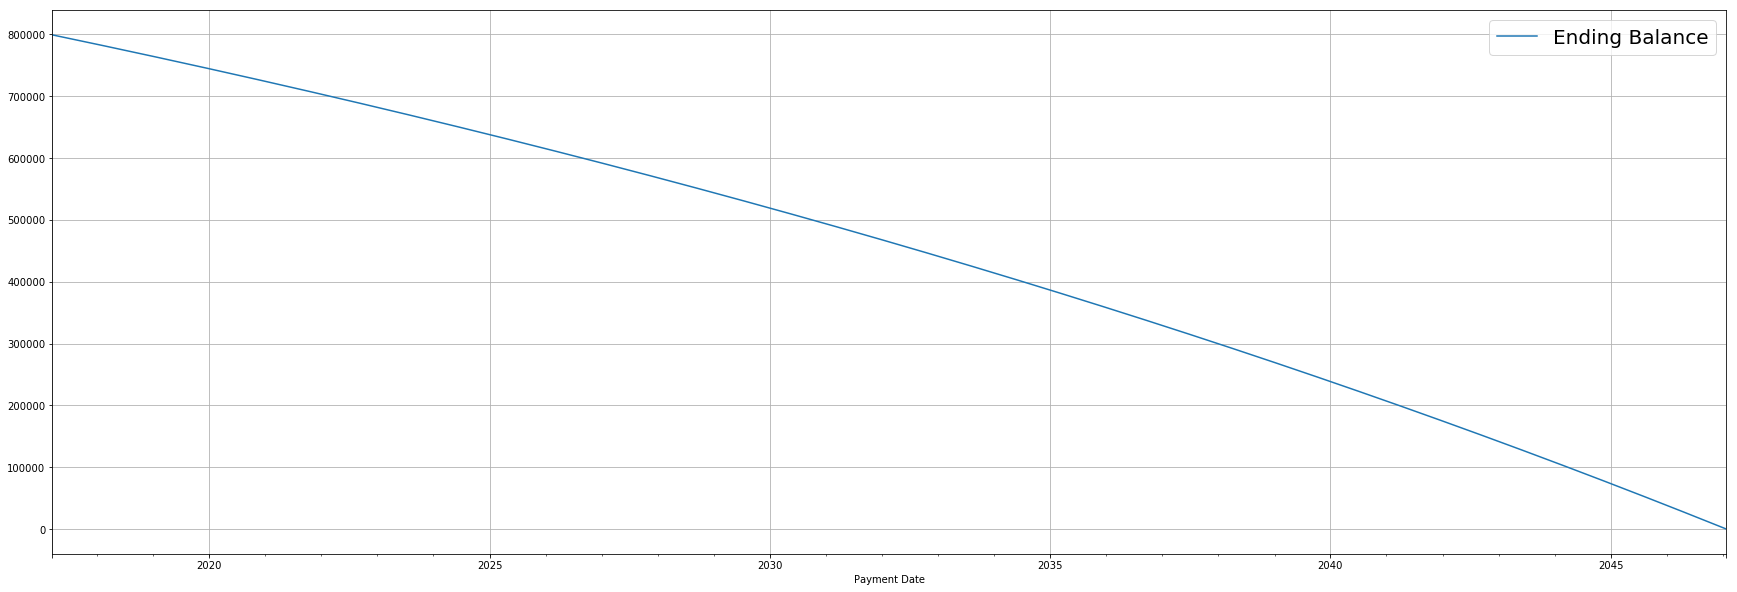

In [15]:
amort_df.plot(y='Ending Balance', grid=True, figsize=(30,10)).legend(loc=1, prop={'size':20})

<br>
**We know that the bi-weekly payment comprises an interest component and a  principal repayment component, and that, over the life of the loan, the former decreases while the latter increases. Let’s see if our amortisation schedule validates this understanding.**

In [16]:
annual_df = amort_df.groupby(by=amort_df.index.year).last()

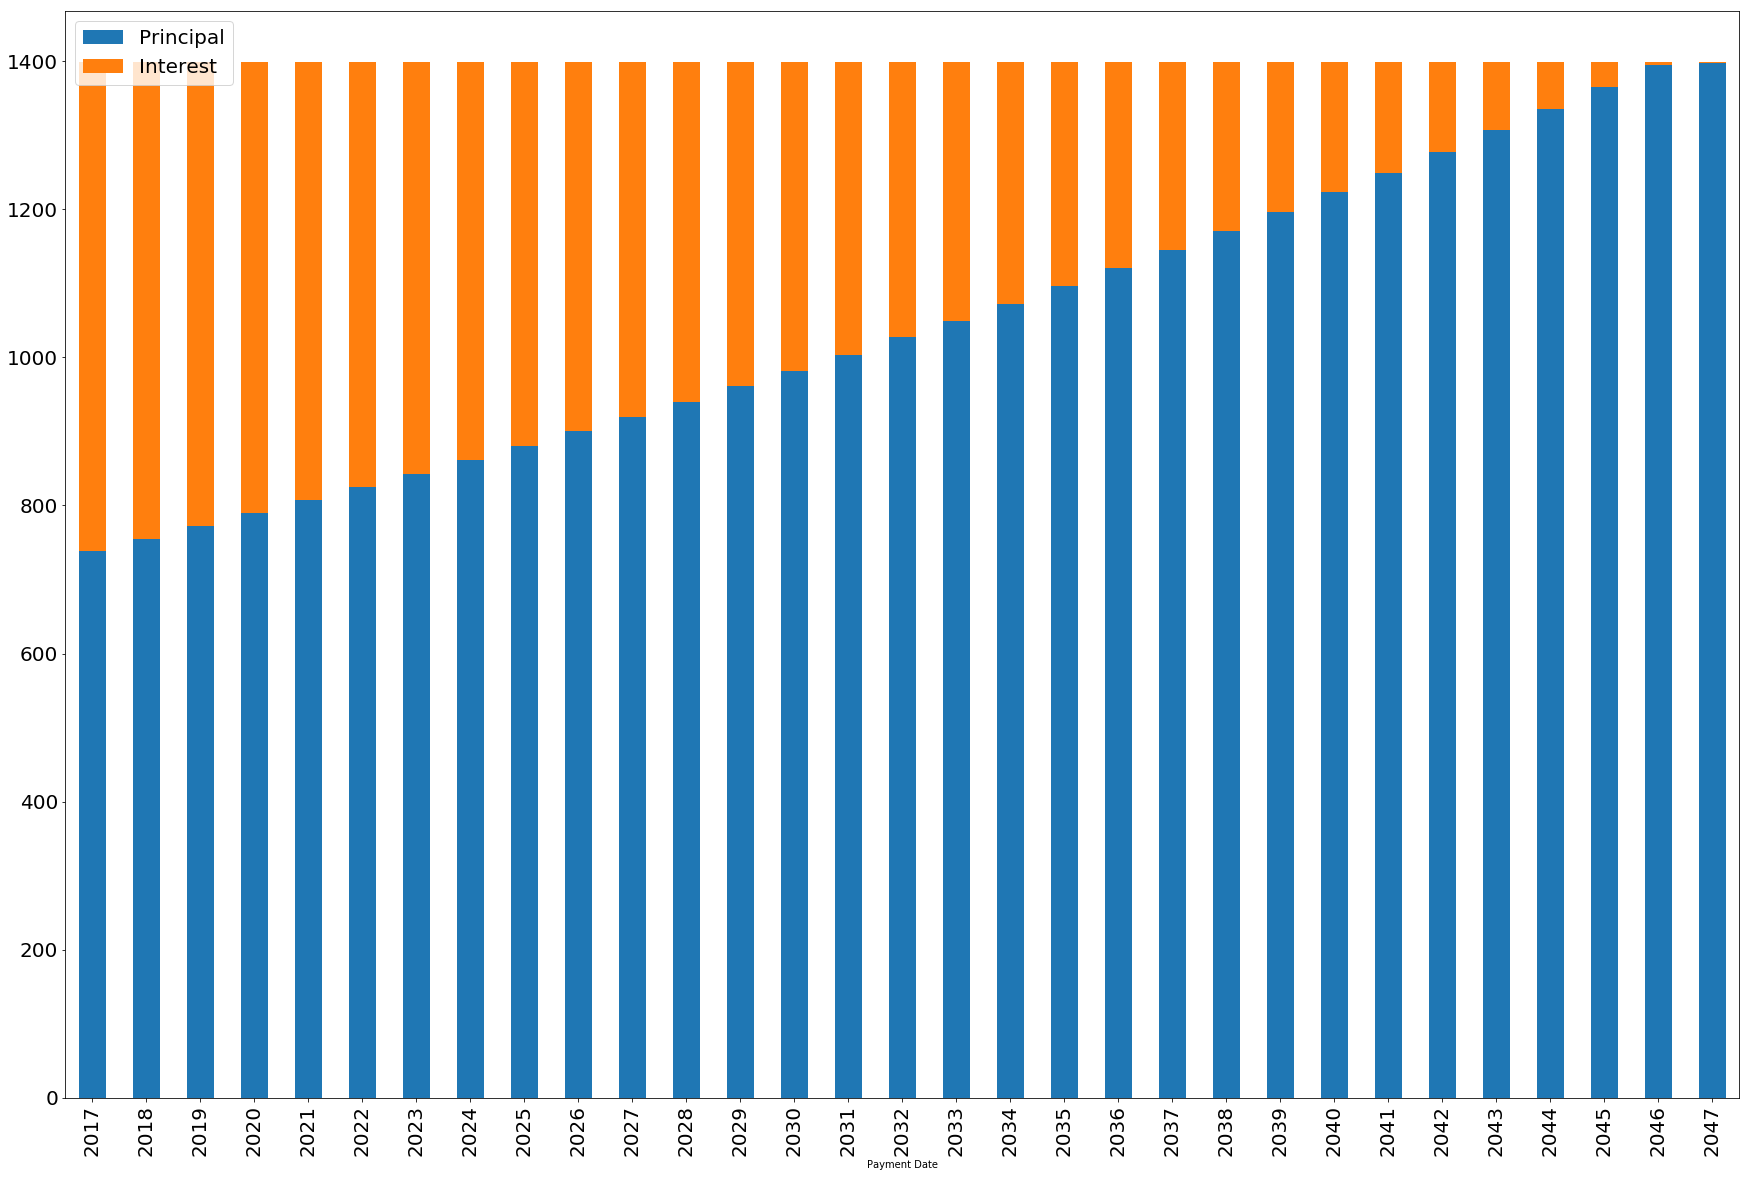

In [17]:
annual_df.plot(y=['Principal', 'Interest'],
               kind='bar',
               stacked=True,
               figsize=(30, 20), fontsize=20).legend(loc=2, prop={'size':20})

<br>**Indeed, the interest component (orange) decreases while the principal component (blue) increases as we approach loan maturity.**